In [ ]:
!pip install pyDOE
!pip install tensorflow_addons

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=e44360772e504c89f4effb21d5cc15599f85229abee046d12e3ffa14e896c7b2
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE
     |████████████████████████████████| 706kB 5.8MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt 
import imageio
import os
from google.colab import files

plt.rcParams.update({'font.size': 14})
tf.keras.backend.set_floatx('float64')

In [ ]:
# Gravitational constant
g = tf.constant(9.80616, dtype=tf.float64)

# Radius of Earth
a = tf.constant(6.37122e6, dtype=tf.float64)

# Angular velocity
Omega = tf.constant(7.292e-5, dtype=tf.float64)

In [ ]:
# Scales of problem
T = 86400
L = a.numpy()
U = L/T
HH = a.numpy()**2/(T**2*g.numpy())

In [ ]:
# Choose one of the Williamson test cases
williamson = 6

### Initial conditions

In [ ]:
if williamson==2: # (Nonlinear geostrophic flow)
  
  days = 5
  c = 1.0
  H = c*HH
  alpha, R, lmbd0, tht0 = 0.0, a.numpy()/3, 3*np.pi/2, 0
  u00, h00 = 2*np.pi*a.numpy()/(12*86400), 2.94e4
  v00 = u00

  u0 = lambda lmbd, tht: u00*(np.cos(tht)*np.cos(alpha)+np.sin(tht)*np.cos(lmbd)*np.sin(alpha))/U
  v0 = lambda lmbd, tht: -v00*np.sin(lmbd)*np.sin(alpha)/U
  h0 = lambda lmbd, tht: (h00 - (a.numpy()*Omega.numpy()*u00+u00**2/2)*(-np.cos(lmbd)*np.cos(tht)*np.sin(alpha)+np.sin(tht)*np.cos(alpha))**2)/g.numpy()/H
  hs0 = lambda lmbd, tht: tf.sin(0.0*lmbd) + tf.sin(0.0*tht)

elif williamson==5: # (Flow over mountain)

  days = 15
  c = 20
  H = c*HH
  alpha, R, lmbd0, tht0 = 0.0, tf.constant(np.pi/9, dtype=tf.float64), 3*np.pi/2-2*np.pi, np.pi/6
  u00, h00, hs00 = 20, 5960, 2000
  v00 = u00

  u0 = lambda lmbd, tht: u00*(np.cos(tht)*np.cos(alpha)+np.sin(tht)*np.cos(lmbd)*np.sin(alpha))/U
  v0 = lambda lmbd, tht: -v00*np.sin(lmbd)*np.sin(alpha)/U
  
  r =  lambda lmbd, tht: tf.sqrt(tf.minimum(R**2, (lmbd-lmbd0)**2+(tht-tht0)**2))
  hs0 = lambda lmbd, tht: hs00*(1.0-r(lmbd,tht)/R)/H
  h0 = lambda lmbd, tht: (g.numpy()*h00 - (a.numpy()*Omega.numpy()*u00+u00**2/2)*(-np.cos(lmbd)*np.cos(tht)*np.sin(alpha)+np.sin(tht)*np.cos(alpha))**2)/g.numpy()/H
  
elif williamson==6: # (Rossby-Haurwitz wave)

  days = 14
  c = 20
  H = c*HH
  omega, R = 7.848e-6, 4
  K, h00 = omega, 8000
  
  u0 = lambda lmbd, tht: (a.numpy()*omega*np.cos(tht) + a.numpy()*K*np.cos(tht)**(R-1)*(R*np.sin(tht)**2-np.cos(tht)**2)*np.cos(R*lmbd))/U
  v0 = lambda lmbd, tht: -a.numpy()*K*R*np.cos(tht)**(R-1)*np.sin(tht)*np.sin(R*lmbd)/U

  A = lambda tht: omega/2*(2*Omega.numpy()+omega)*np.cos(tht)**2+0.25*K**2*np.cos(tht)**(2*R)*((R+1)*np.cos(tht)**2 + (2*R**2-R-2)-2*R**2*np.cos(tht)**(-2))
  B = lambda tht: 2*(Omega.numpy()+omega)*K/(R+1)/(R+2)*np.cos(tht)**R*((R**2+2*R+2) - (R+1)**2*np.cos(tht)**2)
  C = lambda tht: 0.25*K**2*np.cos(tht)**(2*R)*((R+1)*np.cos(tht)**2 - (R+2))
  h0 = lambda lmbd, tht: (g.numpy()*h00 + a.numpy()**2*A(tht)+a.numpy()**2*B(tht)*np.cos(R*lmbd)+a.numpy()**2*C(tht)*np.cos(2*R*lmbd))/g.numpy()/H
  hs0 = lambda lmbd, tht: tf.sin(0.0*lmbd) + tf.sin(0.0*tht)

### Plot initial conditions

In [ ]:
# Boundaries of the computational domain
lmbdleft, lmbdright = -np.pi, np.pi
thtlower, thtupper = -np.pi/2, np.pi/2
t0, tfinal = 0, days*86400/T

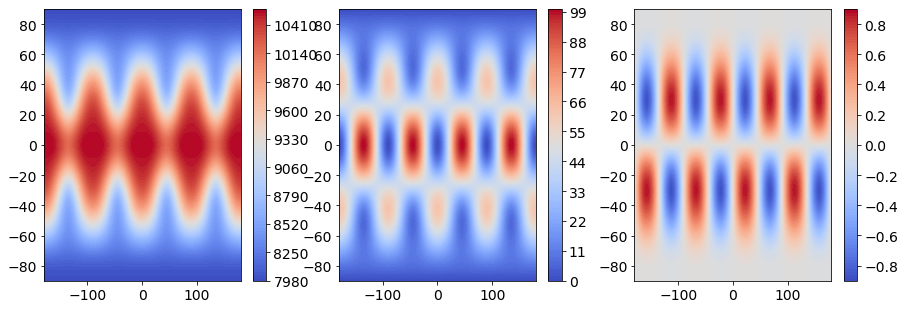

In [ ]:
# Plot initial solution
x = np.linspace(lmbdleft, lmbdright, 100)
y = np.linspace(thtlower, thtupper, 100)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.contourf(360/2/np.pi*X, 360/2/np.pi*Y, H*h0(X,Y), 100, cmap=plt.cm.coolwarm)
plt.colorbar()

plt.subplot(132)
plt.contourf(360/2/np.pi*X, 360/2/np.pi*Y, U*u0(X,Y), 100, cmap=plt.cm.coolwarm)
plt.colorbar()

plt.subplot(133)
plt.contourf(360/2/np.pi*X, 360/2/np.pi*Y, v0(X,Y), 100, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

### Subclassing layers

In [ ]:
class PeriodicSphere(tf.keras.layers.Layer):
  def __init__(self, name=None, **kwargs):
    super(PeriodicSphere, self).__init__(name=name)
    super(PeriodicSphere, self).__init__(**kwargs)

  def call(self, inputs):
    return tf.concat((tf.cos(inputs[1])*tf.cos(inputs[0]),
               tf.cos(inputs[1])*tf.sin(inputs[0]),
               tf.sin(inputs[1])), axis=1)

In [ ]:
# Define the normalization layer
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return 2.0*(inputs-self.xmin)/(self.xmax-self.xmin)-1.0

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

### Define the network

In [ ]:
def build_model(t0, tfinal, n_units=80, n_layers=8, summary=False):

  # Define the network
  inp1 = tf.keras.layers.Input(shape=(1,))
  b1 = Normalize(t0, tfinal)(inp1)

  inp2 = tf.keras.layers.Input(shape=(1,))
  inp3 = tf.keras.layers.Input(shape=(1,))
  b23 = PeriodicSphere()([inp2, inp3])

  b = tf.keras.layers.Concatenate()([b1, b23])

  for i in range(n_layers):
    b = tf.keras.layers.Dense(n_units, 'tanh', kernel_initializer='glorot_normal')(b)
  out = tf.keras.layers.Dense(3, activation='linear')(b)

  model = tf.keras.models.Model([inp1, inp2, inp3], out)
  
  if summary:
    model.summary()

  return model

### Main NN training function

In [ ]:
@tf.function
def train_network(pdes, inits, hs0, c, model):
                          
  # -------------- Training loop -----------------------

  # PDE points and associated self-adaptation weights
  t_pde, x_pde, y_pde, f = pdes[:,:1], pdes[:,1:2], pdes[:,2:3], pdes[:,3:4]

  # Initial value points and associated self-adaptation weights
  t_init, x_init, y_init = inits[:,:1], inits[:,1:2], inits[:,2:3]
  u_init, v_init, h_init =inits[:,3:4], inits[:,4:5], inits[:,5:6]

  # ----------- Train the network ----------------

  # Outer gradient for tuning network parameters
  with tf.GradientTape(persistent=True) as tape:

    # Inner gradient for derivatives of u wrt x and t
    with tf.GradientTape(persistent=True) as tape2:
          
      tape2.watch(t_pde), tape2.watch(x_pde), tape2.watch(y_pde)
          
      uvh = model([t_pde, x_pde, y_pde], training=True)
      u, v, h = uvh[:,:1], uvh[:,1:2], uvh[:,2:]
      hs = h - hs0(x_pde, y_pde)
      vcostht = v*tf.cos(y_pde)

    # Derivatives needed to define the SWE
    [dudt, dudx, dudy] = tape2.gradient(u, [t_pde, x_pde, y_pde])
    [dvdt, dvdx, dvdy] = tape2.gradient(v, [t_pde, x_pde, y_pde])
    [dhdt, dhdx, dhdy] = tape2.gradient(h, [t_pde, x_pde, y_pde])
    [dhsdx, dhsdy] = tape2.gradient(hs, [x_pde, y_pde])
    [dvcosthtdy] = tape2.gradient(vcostht, [y_pde])

    #  Solve the shallow-water equations
    eqnu = dudt + u/tf.cos(y_pde)*dudx + v*dudy - (f+u*tf.tan(y_pde))*v + c/tf.cos(y_pde)*dhdx
    eqnv = dvdt + u/tf.cos(y_pde)*dvdx + v*dvdy + (f+u*tf.tan(y_pde))*u + c*dhdy
    eqnh = dhdt + u/tf.cos(y_pde)*dhsdx + v*dhsdy + hs/tf.cos(y_pde)*(dudx + dvcosthtdy) 

    # Define the PDE loss  
    PDEloss_u = tf.reduce_mean(tf.square(eqnu))
    PDEloss_v = tf.reduce_mean(tf.square(eqnv))
    PDEloss_h = tf.reduce_mean(tf.square(eqnh))

    PDEloss = PDEloss_u + PDEloss_v + PDEloss_h

    # Define the initial value loss
    uvh_init_pred = model([t_init, x_init, y_init], training=True)
    u_init_pred, v_init_pred, h_init_pred = uvh_init_pred[:,:1], uvh_init_pred[:,1:2], uvh_init_pred[:,2:] 
        
    ICloss_u = tf.reduce_mean(tf.square(u_init-u_init_pred))
    ICloss_v = tf.reduce_mean(tf.square(v_init-v_init_pred))
    ICloss_h = tf.reduce_mean(tf.square(h_init-h_init_pred))

    ICloss = ICloss_u + ICloss_v + ICloss_h                  

  # Compute loss weighting
  gradPDE = tape.gradient(PDEloss, model.trainable_variables)
  gradIVP = tape.gradient(ICloss, model.trainable_variables)
  gradPDE_f = tf.concat([tf.reshape(p, [-1]) for p in gradPDE], axis=0)
  gradIVP_f = tf.concat([tf.reshape(p, [-1]) for p in gradIVP], axis=0)

  # Project conflicting gradients
  if tf.reduce_sum(tf.multiply(gradIVP_f, gradPDE_f)) < 0:
    if tf.random.uniform([1]) < 0.5:
      proj = tf.reduce_sum(tf.multiply(gradPDE_f, gradIVP_f))/tf.reduce_sum(tf.square(gradIVP_f))
      gradPDE = [gPDE - proj*gIVP for gPDE, gIVP in zip(gradPDE, gradIVP)]
    else:
      proj = tf.reduce_sum(tf.multiply(gradPDE_f, gradIVP_f))/tf.reduce_sum(tf.square(gradPDE_f))
      gradIVP = [gIVP - proj*gPDE for gPDE, gIVP in zip(gradPDE, gradIVP)]

  # Compute the gradient of the global loss wrt the model parameters
  grads = [gPDE+gIVP for gPDE, gIVP in zip(gradPDE, gradIVP)]
    
  return PDEloss, ICloss, grads

### Define the collocation points

In [ ]:
def defineCollocationPoints(t_bdry, x_bdry, y_bdry, u0, v0, h0, N_pde=50000, N_iv=10000):

  # Convert input to numpy array
  t_bdry, x_bdry, y_bdry = np.array(t_bdry), np.array(x_bdry), np.array(y_bdry)
  
  # Uniform random sampling on a sphere
  txy_min = np.array([t_bdry[0], x_bdry[0], 0])
  txy_max = np.array([t_bdry[1], x_bdry[1], 1])  
  pde_points = txy_min + (txy_max - txy_min)*lhs(3, N_pde)
  t_pde = pde_points[:, 0] 
  x_pde = pde_points[:, 1]
  y_pde = np.arccos(1-2*pde_points[:, 2]) + y_bdry[0]

  f = 2*Omega*T*np.sin(y_pde)
  
  # Stack all the PDE point data together
  pdes = np.column_stack([t_pde, x_pde, y_pde, f]).astype(np.float64)
  pdes = pdes[np.argsort(pdes[:,0])]  

  # Uniform random sampling on a sphere for initial values
  init_points = txy_min[1:] + (txy_max[1:] - txy_min[1:])*lhs(2, N_iv)
  x_init = init_points[:, 0]
  y_init = np.arccos(1-2*init_points[:, 1]) + y_bdry[0]
  t_init = t_bdry[0]+0*x_init

  # Stack all the ivp data together
  inits = np.column_stack([t_init, x_init, y_init]).astype(np.float64)

  return (pdes, f, inits)

In [ ]:
N_pde, N_iv = 100000, 10000
(pdes, f, inits) = defineCollocationPoints([t0, tfinal], [lmbdleft, lmbdright], [thtlower, thtupper], u0, v0, h0, N_pde, N_iv)

### Main training routine

In [ ]:
def PINNtrain(pde_points, f, inits, hs0, c, epochs=10000):

  N_pde, N_iv = len(pde_points), len(inits)

  # Batch sizes
  bs_pdes, bs_inits = N_pde//160, N_iv//80

  # Boundaries for the models
  # model_boundaries = [5000*i for i in range(epochs//5000+1)]
  model_boundaries = [15000*i for i in range(epochs//15000+1)]
  lr_model = [1e-3,1e-3/np.sqrt(10),1e-3/np.sqrt(10),1e-4,1e-4,1e-4,1e-4,1e-4]

  print(model_boundaries)
  print(lr_model)

  nr_boundaries = len(model_boundaries)-1
  k = 0

  # initial value points
  t_init, x_init, y_init = inits[:,0], inits[:,1], inits[:,2]

  epoch_loss = np.zeros(epochs)
  nr_batches = 0

  # Main training loop
  for i in range(epochs):

    # Train a new model
    if np.mod(i, model_boundaries[k]) == 0:
      k +=1

      # Generate the tf.Dataset for the initial data
      if k==1: # Use the actual initial conditions
        u_init = u0(x_init, y_init)
        v_init = v0(x_init, y_init)
        h_init = h0(x_init, y_init)
      else: # Use the previous model
        t_init = (k-1)*tfinal/nr_boundaries + 0*t_init
        uvh = model([np.expand_dims(t_init, axis=1), 
                     np.expand_dims(x_init, axis=1), 
                     np.expand_dims(y_init, axis=1)]) 
        u_init, v_init, h_init = uvh[:,0], uvh[:,1], uvh[:,2]  

        # Save the previous model
        fname = "model" + str(k-1) + ".h5"
        model.save(fname)

      inits = np.column_stack([t_init, x_init, y_init, u_init, v_init, h_init])

      ds_init = tf.data.Dataset.from_tensor_slices(inits)
      ds_init = ds_init.cache().shuffle(N_iv).batch(bs_inits)
  
      # Generate the tf.Dataset for the collocation points
      N_ds = k*N_pde//nr_boundaries
      N_ds_ = (k-1)*N_pde//nr_boundaries
      pts = pde_points[N_ds_:N_ds]
      t_min, t_max = pts[:,0].min(), pts[:,0].max()

      ds_pde = tf.data.Dataset.from_tensor_slices(pde_points[N_ds_:N_ds])
      ds_pde = ds_pde.cache().shuffle(N_ds-N_ds_).batch(bs_pdes)
      ds = tf.data.Dataset.zip((ds_pde, ds_init))
      ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

      # Generate a new model
      opt = tf.keras.optimizers.Adam(lr_model[k-1])
      model = build_model(t_min, t_max) 

      # Copy over weights from old model
      if k>1:
        print("Copy over weights from previous model...")
        fname = "model" + str(k-1) + ".h5"
        model_ = tf.keras.models.load_model(fname, custom_objects={'Normalize': Normalize, 
                                                                   'PeriodicSphere': PeriodicSphere})
        model.set_weights(model_.get_weights())

      print("\nTraining model no. {} for initial time {: 4.2f}, running over interval [{: 4.2f},{: 4.2f}] with lr={}.\n".format(k, t_init[0], t_min, t_max, lr_model[k-1]))

    # Training for that epoch
    for (pdes, inits) in ds:

      # Train the network
      PDEloss, ICloss, grads = train_network(pdes, inits, hs0, c, model)

      # Gradient step
      opt.apply_gradients(zip(grads, model.trainable_variables))

      epoch_loss[i] += PDEloss + ICloss
      nr_batches += 1

    # Get total epoch loss
    epoch_loss[i] /= nr_batches
    nr_batches = 0

    if (np.mod(i, 100)==0):
      print("PDE loss, IV loss in {}th epoch: {: 6.4f}, {: 6.4f}.".format(i, PDEloss, ICloss))

  # Add the last model
  fname = "model" + str(k) + ".h5"
  model.save(fname)

  return epoch_loss, k

### Train and visualize

In [ ]:
epochs = 75000
loss, nr_models = PINNtrain(pdes, f, inits, hs0, c, epochs)

[0, 15000, 30000, 45000, 60000, 75000]
[0.001, 0.00031622776601683794, 0.00031622776601683794, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]

Training model no. 1 for initial time  0.00, running over interval [ 0.00, 2.80] with lr=0.001.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in remainder


PDE loss, IV loss in 0th epoch:  0.2038,  0.6976.
PDE loss, IV loss in 100th epoch:  0.0198,  0.2709.
PDE loss, IV loss in 200th epoch:  0.0253,  0.2347.
PDE loss, IV loss in 300th epoch:  0.0254,  0.0034.
PDE loss, IV loss in 400th epoch:  0.0293,  0.0021.
PDE loss, IV loss in 500th epoch:  0.0248,  0.0018.
PDE loss, IV loss in 600th epoch:  0.0147,  0.0009.
PDE loss, IV loss in 700th epoch:  0.0288,  0.0008.
PDE loss, IV loss in 800th epoch:  0.0102,  0.0005.
PDE loss, IV loss in 900th epoch:  0.0113,  0.0009.
PDE loss, IV loss in 1000th epoch:  0.0141,  0.0008.
PDE loss, IV loss in 1100th epoch:  0.0355,  0.0016.
PDE loss, IV loss in 1200th epoch:  0.0092,  0.0005.
PDE loss, IV loss in 1300th epoch:  0.0068,  0.0003.
PDE loss, IV loss in 1400th epoch:  0.0100,  0.0006.
PDE loss, IV loss in 1500th epoch:  0.0201,  0.0008.
PDE loss, IV loss in 1600th epoch:  0.0068,  0.0003.
PDE loss, IV loss in 1700th epoch:  0.0089,  0.0004.
PDE loss, IV loss in 1800th epoch:  0.0075,  0.0003.
PDE l

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

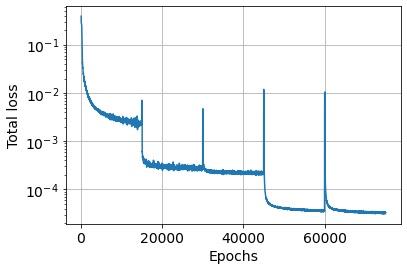

In [ ]:
steps = 101
plt.semilogy(range(steps//2, epochs-steps//2), moving_average(loss, steps))
plt.xlabel('Epochs')
plt.ylabel('Total loss')
plt.grid()

fname = 'Loss_Williamson_' + str(williamson) + '_epochs' + str(epochs) + '.png'
plt.savefig(fname)
files.download(fname)

In [ ]:
# Composite prediction function
def predict(nr_models,t,x,y):
  
  total_steps = len(t)
  steps_per_model = total_steps//nr_models
  u = np.zeros((total_steps, 1))
  v = np.zeros((total_steps, 1)) 
  h = np.zeros((total_steps, 1))
  uy = np.zeros((total_steps, 1))
  vx = np.zeros((total_steps, 1)) 

  for i in range(nr_models):
    curr_model = "model" + str(i+1) + '.h5'
    model = tf.keras.models.load_model(curr_model, custom_objects={'Normalize': Normalize, 
                                                                   'PeriodicSphere': PeriodicSphere})
    
    tt = tf.Variable(t[i*steps_per_model:(i+1)*steps_per_model,])
    xx = tf.Variable(x[i*steps_per_model:(i+1)*steps_per_model,])
    yy = tf.Variable(y[i*steps_per_model:(i+1)*steps_per_model,])

    with tf.GradientTape(persistent=True) as tape:
      uvh = model([tt,xx,yy])
      uu, vv, hh = uvh[:,:1], uvh[:,1:2], uvh[:,2:]

    u[i*steps_per_model:(i+1)*steps_per_model,:] = uu
    v[i*steps_per_model:(i+1)*steps_per_model,:] = vv
    h[i*steps_per_model:(i+1)*steps_per_model,:] = hh    
    uy[i*steps_per_model:(i+1)*steps_per_model,:] = tape.gradient(uu, yy)
    vx[i*steps_per_model:(i+1)*steps_per_model,:] = tape.gradient(vv, xx)
    
  return u, v, h, uy, vx

In [ ]:
# Grid where to evaluate the model
l, m, n = days+1, 150, 75
t = np.linspace(t0, tfinal, l)
x = np.linspace(lmbdleft, lmbdright, m)
y = np.linspace(thtlower, thtupper, n)
T_p, X_p, Y_p  = np.meshgrid(t,x,y, indexing='ij')

dt = t[1]-t[0]

tt = np.expand_dims(T_p.flatten(), axis=1)
xx = np.expand_dims(X_p.flatten(), axis=1)
yy = np.expand_dims(Y_p.flatten(), axis=1)

u, v, h, u_y, v_x = predict(nr_models,tt,xx,yy)
u, v, h = np.reshape(u, (l, m, n)), np.reshape(v, (l, m, n)), np.reshape(h, (l, m, n))
u_y, v_x = np.reshape(u_y, (l, m, n)), np.reshape(v_x, (l, m, n))

u_y, v_x = U*u_y/L, U*v_x/np.cos(Y_p)/L
hs = hs0(X_p, Y_p) 

# Conserved quantities
# PE
pvv = 0.5*H*h*((v_x - u_y + 2*Omega*np.sin(Y_p))/(H*(h-hs.numpy() )))**2
pv = (pvv.numpy()).sum(axis=(1,2))

# Mass
mass = H*(h-hs.numpy()).sum(axis=(1,2))

# Energy
# energy = 0.5*H*U**2*((h-hs.numpy())*(u**2+v**2))+0.5*H**2*(h-hs.numpy())**2
# energy = energy.sum(axis=(1,2))
energy2 = 0.5*H*U**2*((h-hs.numpy())*(u**2+v**2))+0.5*H**2*(h**2-hs.numpy()**2)
energy = energy2.sum(axis=(1,2))

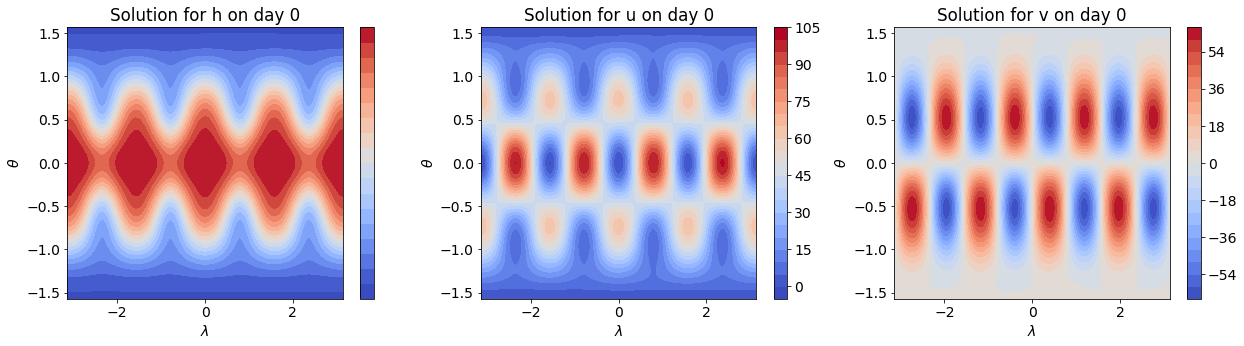

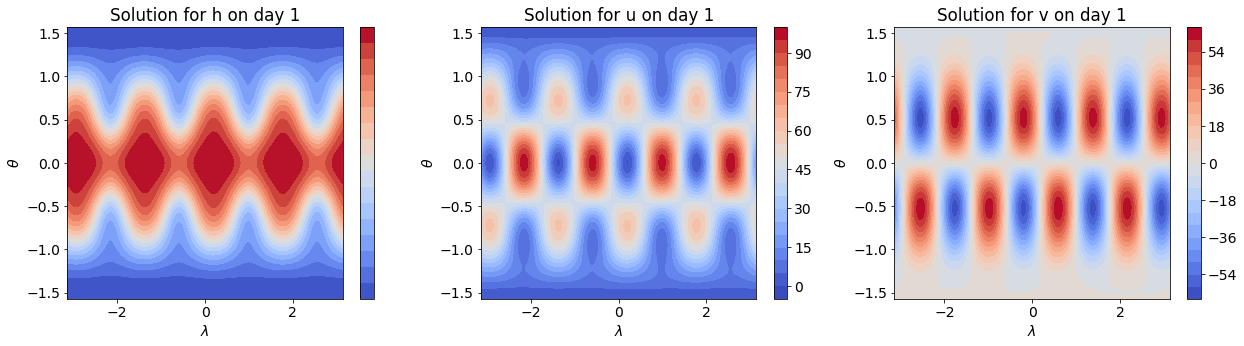

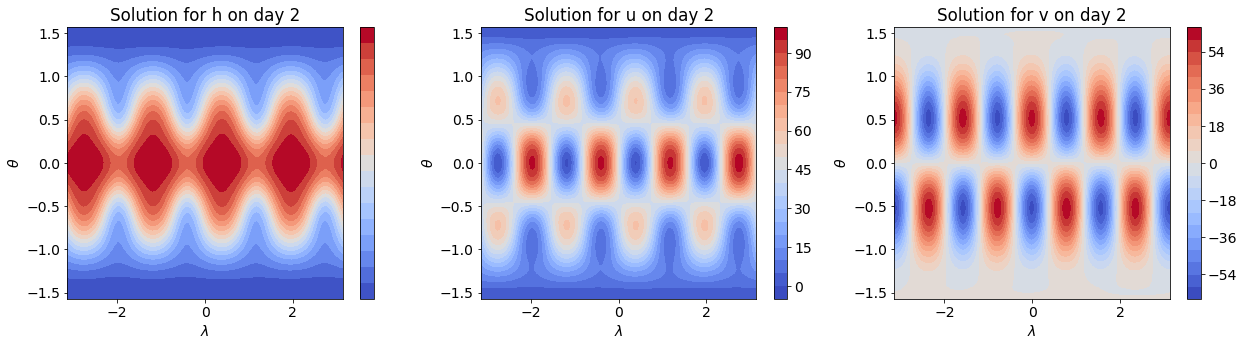

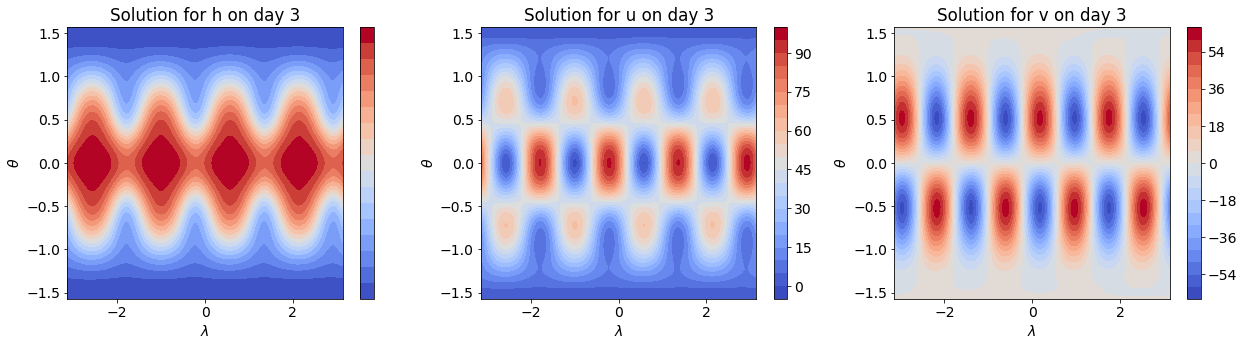

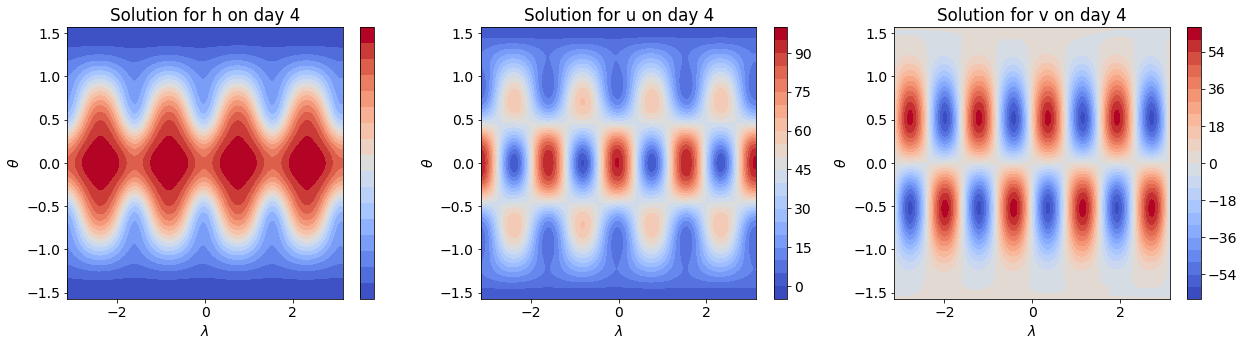

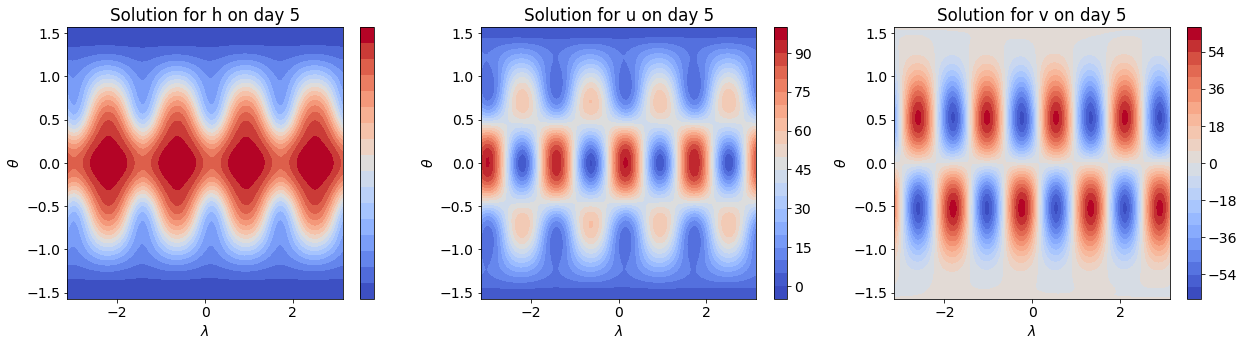

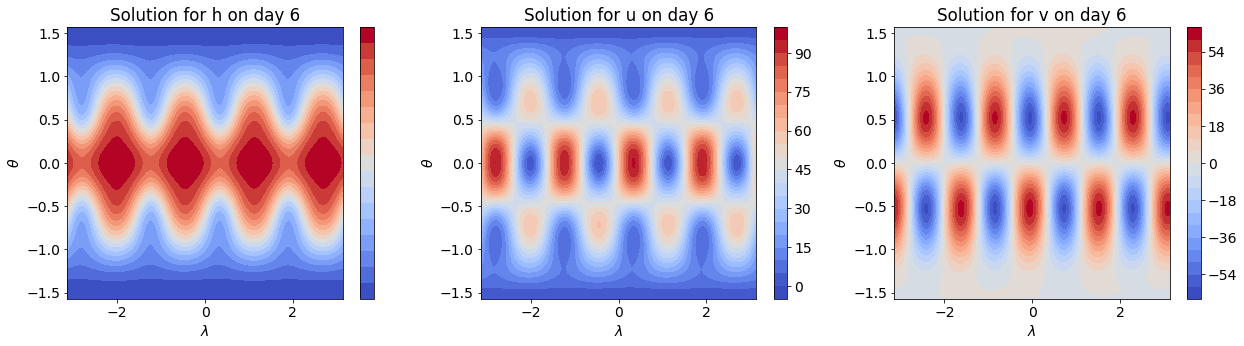

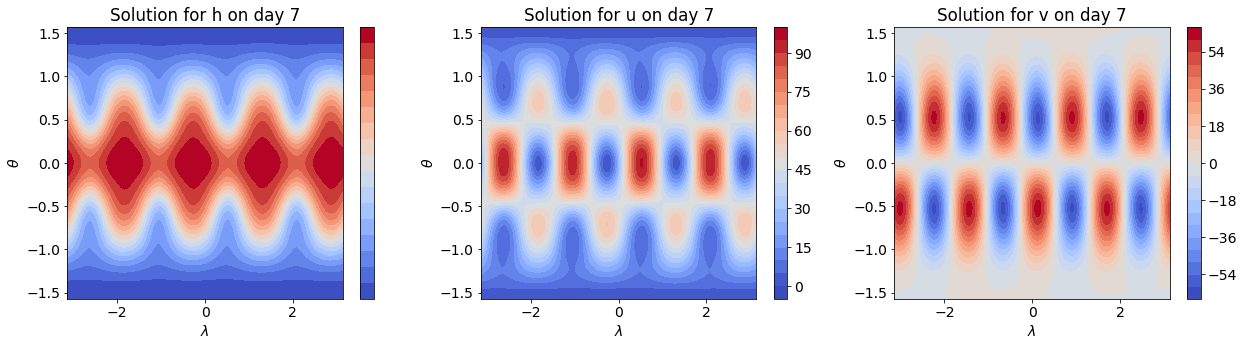

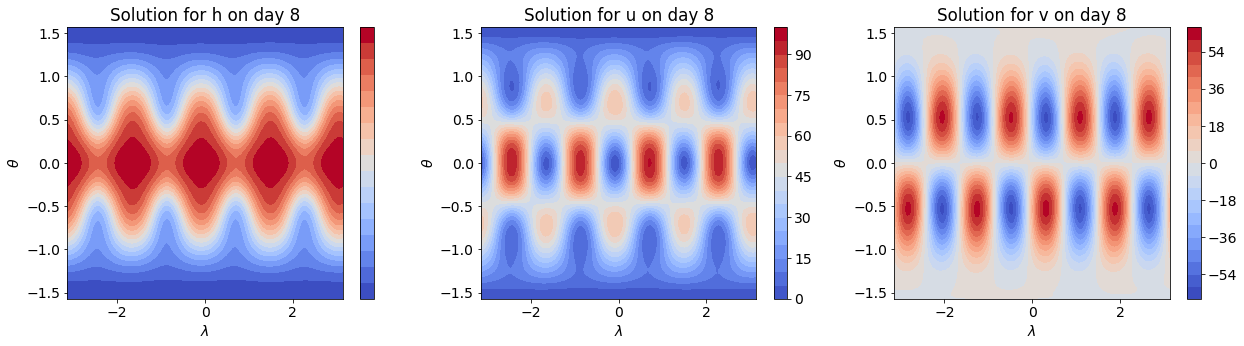

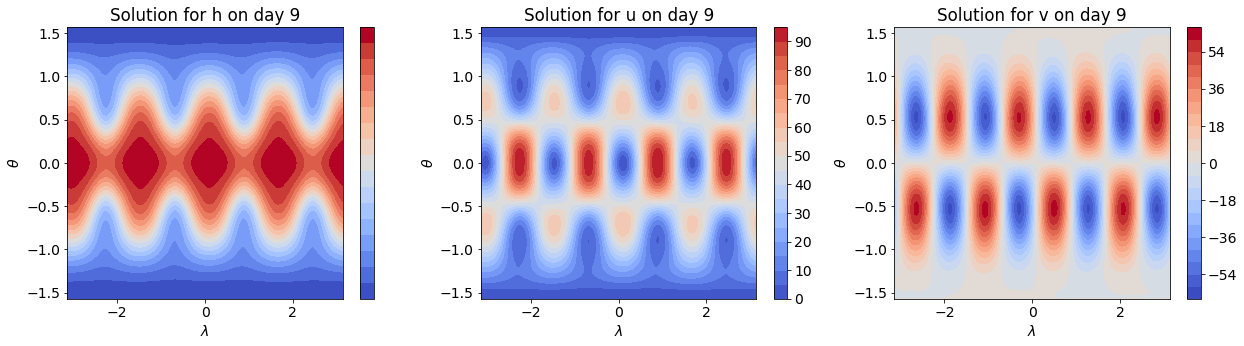

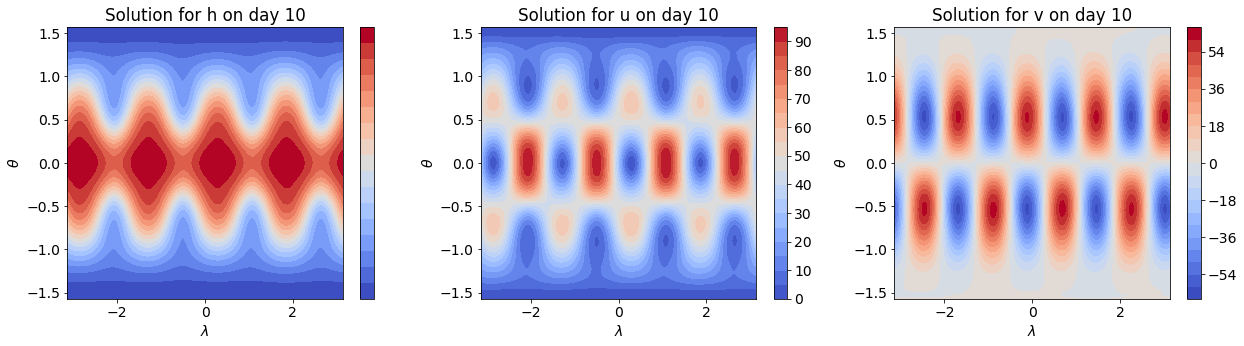

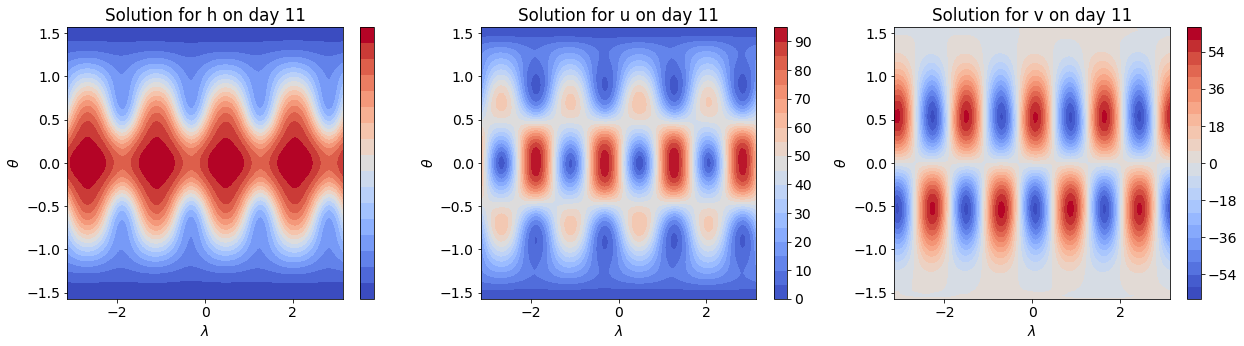

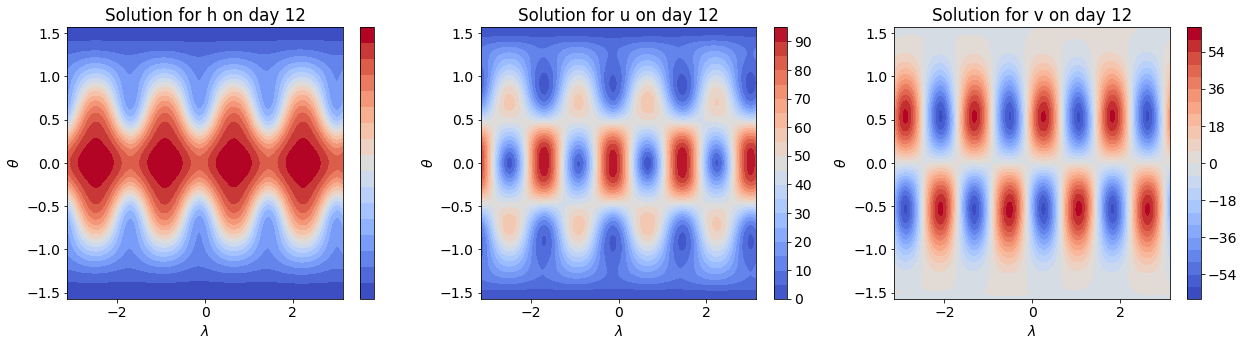

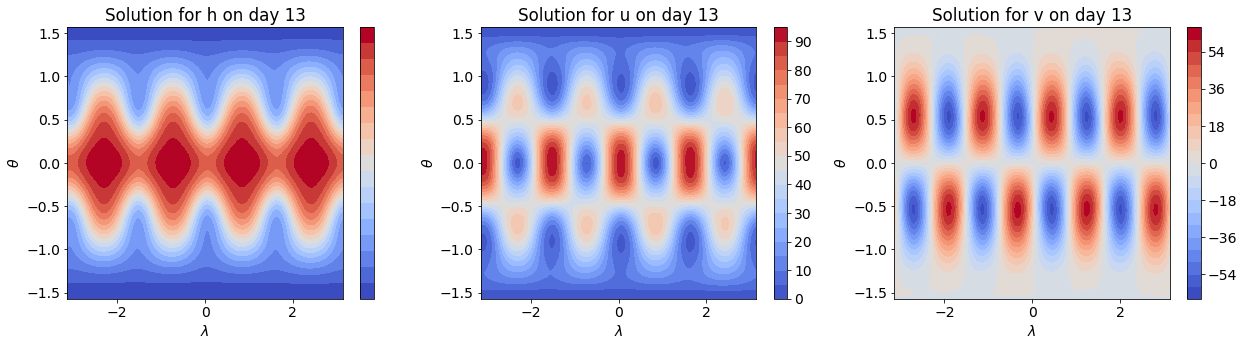

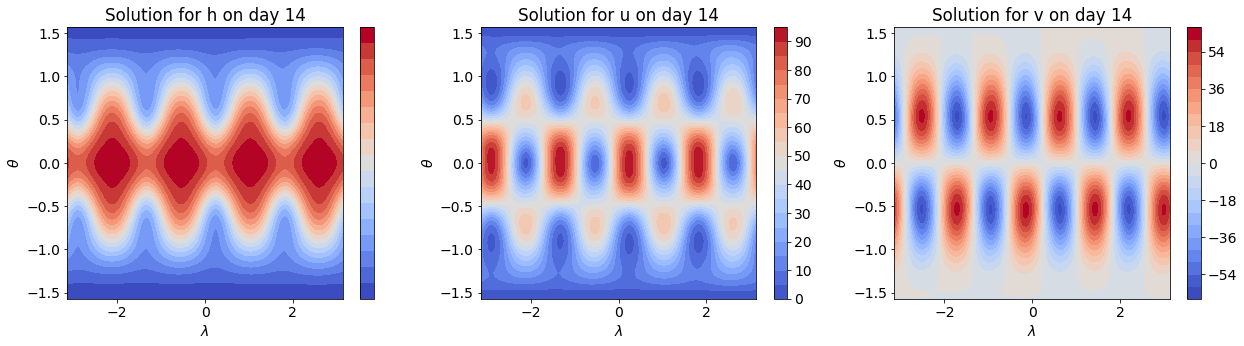

In [ ]:
plot_steps = [i for i in range(l)]
for i in plot_steps:
  plt.figure(figsize=(21,5))
  plt.subplot(131)
  plt.contourf(X_p[i,], Y_p[i,], H*h[i,], 21, cmap=plt.cm.coolwarm,
               vmin=H*h[i,].min(), vmax=H*h[i,].max())
  plt.colorbar(ticks=[5000+200*j for j in range(6)])
  plt.title('Solution for h on day{: 2.0f}'.format(i*dt))
  plt.xlabel(r'$\lambda$')
  plt.ylabel(r'$\theta$')

  plt.subplot(132)
  plt.contourf(X_p[i,], Y_p[i,], U*u[i,], 21, cmap=plt.cm.coolwarm,
               vmin=U*u[i,].min(), vmax=U*u[i,].max())
  # plt.colorbar(ticks=[20*j for j in range(6)])
  plt.colorbar()
  plt.title('Solution for u on day{: 2.0f}'.format(i*dt))
  plt.xlabel(r'$\lambda$')
  plt.ylabel(r'$\theta$')

  plt.subplot(133)
  plt.contourf(X_p[i,], Y_p[i,], U*v[i,], 21, cmap=plt.cm.coolwarm,
               vmin=U*v[i,].min(), vmax=U*v[i,].max())
  plt.colorbar()
  # plt.colorbar(ticks=[60-20*j for j in range(8)])
  plt.title('Solution for v on day{: 2.0f}'.format(i*dt))
  plt.xlabel(r'$\lambda$')
  plt.ylabel(r'$\theta$')

  plt.show()

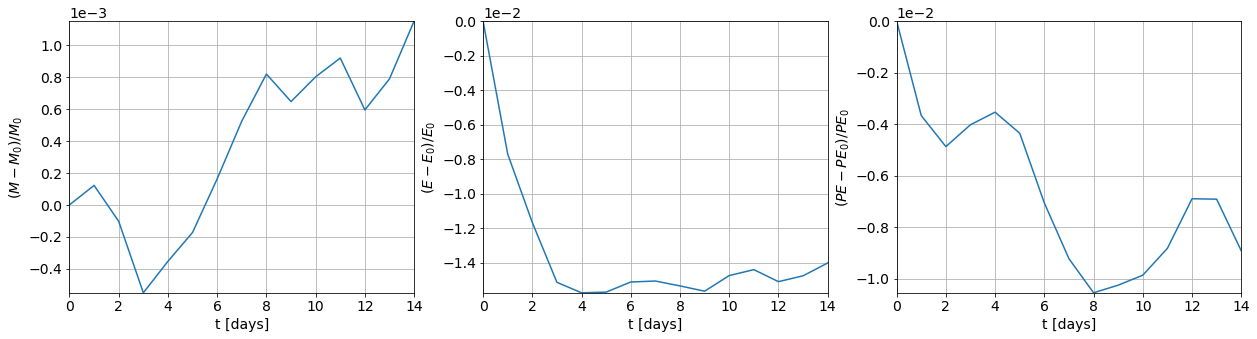

In [ ]:
t = np.linspace(0, tfinal, l)

plt.figure(figsize=(21, 5))

ax1 = plt.subplot(131)
rmass = (mass-mass[0])/mass[0]
plt.plot(t, rmass)
plt.xlabel('t [days]')
plt.ylabel(r'$(M-M_0)/M_0$')
plt.axis([0,tfinal,rmass.min(), rmass.max()])
plt.grid()
ax1.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax2 = plt.subplot(132)
renergy = (energy-energy[0])/energy[0]
plt.plot(t, renergy)
# renergy2 = (energy2-energy2[0])/energy2[0]
# plt.plot(t, renergy2)
plt.xlabel('t [days]')
plt.ylabel(r'$(E-E_0)/E_0$')
plt.axis([0,tfinal,renergy.min(), renergy.max()])
plt.grid()
ax2.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax3 = plt.subplot(133)
rpv = (pv-pv[0])/pv[0]
plt.plot(t, rpv)
plt.xlabel('t [days]')
plt.ylabel(r'$(PE-PE_0)/PE_0$')
plt.axis([0,tfinal,rpv.min(), rpv.max()])
plt.grid()
ax3.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

fname = 'CLs_Williamson_' + str(williamson) + '_epochs' + str(epochs) + '.png'
plt.savefig(fname)
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

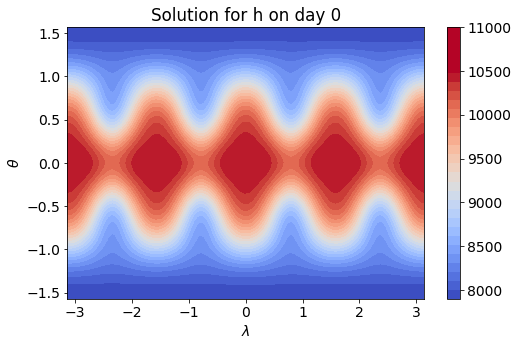

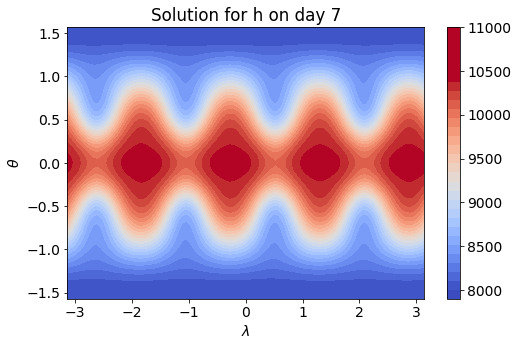

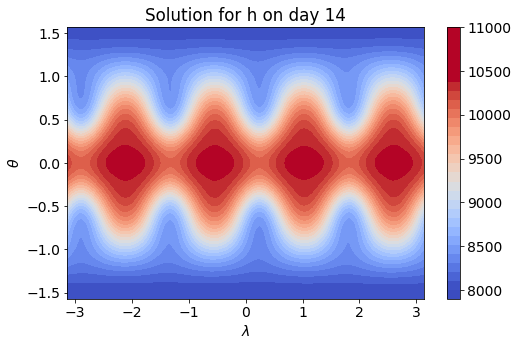

In [ ]:
# Rossby-Haurwitz wave time steps needed
plot_steps = [0, 7, 14]
for i in plot_steps:
  plt.figure(figsize=(8,5))
  plt.subplot(111)
  plt.contourf(X_p[i,], Y_p[i,], H*h[i,], np.linspace(7900,11000, 31), cmap=plt.cm.coolwarm,
               vmin=H*h[i,].min(), vmax=H*h[i,].max())
  plt.colorbar(ticks=[8000+500*i for i in range(7)])
  plt.title('Solution for h on day{: 2.0f}'.format(i*dt))
  plt.xlabel(r'$\lambda$')
  plt.ylabel(r'$\theta$')
  fname = "Solution_Willimason_" + str(williamson) + '_step_' + str(i) + '_epochs' + str(epochs) + '.png'
  plt.savefig(fname)
  files.download(fname)


In [ ]:
t = np.linspace(0, tfinal, l)

plt.figure(figsize=(8, 5))
ax1 = plt.subplot(111)
rmass = (mass-mass[0])/mass[0]
plt.plot(t, rmass)
plt.xlabel('t [days]')
plt.ylabel(r'$(M-M_0)/M_0$')
plt.axis([0,tfinal,rmass.min(), rmass.max()])
plt.grid()
plt.title('Relative change of M')
ax1.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
fname = 'M_Williamson_' + str(williamson) + '_epochs' + str(epochs) + '.png'
plt.savefig(fname)
files.download(fname)

plt.figure(figsize=(8, 5))
ax2 = plt.subplot(111)
renergy = (energy-energy[0])/energy[0]
plt.plot(t, renergy)
plt.xlabel('t [days]')
plt.ylabel(r'$(E-E_0)/E_0$')
plt.axis([0,tfinal,renergy.min(), renergy.max()])
plt.grid()
plt.title('Relative change of E')
ax2.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
fname = 'E_Williamson_' + str(williamson) + '_epochs' + str(epochs) + '.png'
plt.savefig(fname)
files.download(fname)

plt.figure(figsize=(8, 5))
ax3 = plt.subplot(111)
rpv = (pv-pv[0])/pv[0]
plt.plot(t, rpv)
plt.xlabel('t [days]')
plt.ylabel(r'$(PE-PE_0)/PE_0$')
plt.axis([0,tfinal,rpv.min(), rpv.max()])
plt.grid()
plt.title('Relative change of PE')
ax3.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
fname = 'PE_Williamson_' + str(williamson) + '_epochs' + str(epochs) + '.png'
plt.savefig(fname)
files.download(fname)


In [ ]:
# Grid where to evaluate the model
l, m, n = days*10, 150, 75
t = np.linspace(t0, tfinal, l)
x = np.linspace(lmbdleft, lmbdright, m)
y = np.linspace(thtlower, thtupper, n)
T_p, X_p, Y_p  = np.meshgrid(t,x,y, indexing='ij')

dt = t[1]-t[0]

tt = np.expand_dims(T_p.flatten(), axis=1)
xx = np.expand_dims(X_p.flatten(), axis=1)
yy = np.expand_dims(Y_p.flatten(), axis=1)

u, v, h, u_y, v_x = predict(nr_models,tt,xx,yy)
u, v, h = np.reshape(u, (l, m, n)), np.reshape(v, (l, m, n)), np.reshape(h, (l, m, n))
# u_y, v_x = np.reshape(u_y, (l, m, n)), np.reshape(v_x, (l, m, n))

filenames = []
for i in range(l):

  plt.figure(figsize=(21,5))
  plt.subplot(131)
  plt.contourf(X_p[i,], Y_p[i,], H*h[i,], 31, cmap=plt.cm.coolwarm,
               vmin=H*h[i,].min(), vmax=H*h[i,].max())
  plt.colorbar(ticks=[8000+500*i for i in range(7)])
  plt.title('Solution for h on day{: 2.0f}'.format(i*dt))
  plt.xlabel(r'$\lambda$')
  plt.ylabel(r'$\theta$')

  plt.subplot(132)
  plt.contourf(X_p[i,], Y_p[i,], U*u[i,], 31, cmap=plt.cm.coolwarm,
               vmin=U*u[i,].min(), vmax=U*u[i,].max())
  # plt.colorbar(ticks=[20*j for j in range(6)])
  plt.colorbar()
  plt.title('Solution for u on day{: 2.0f}'.format(i*dt))
  plt.xlabel(r'$\lambda$')
  plt.ylabel(r'$\theta$')

  plt.subplot(133)
  plt.contourf(X_p[i,], Y_p[i,], U*v[i,], 31, cmap=plt.cm.coolwarm,
               vmin=U*v[i,].min(), vmax=U*v[i,].max())
  plt.colorbar()
  # plt.colorbar(ticks=[60-20*j for j in range(8)])
  plt.title('Solution for v on day{: 2.0f}'.format(i*dt))
  plt.xlabel(r'$\lambda$')
  plt.ylabel(r'$\theta$')

  filename = f'{i}.png'
  filenames.append(filename)
  plt.savefig(filename)
  plt.close()

with imageio.get_writer('RossbyHaurwitz.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in set(filenames):
  os.remove(filename)